In [1]:
# Imports
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Load input data
charityRawDF = pd.read_csv("./resources/charity_data.csv")
charityRawDF.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [3]:
# PREPROCESSING
# *****************************

charityDF = charityRawDF.copy()

# Target => IS_SUCCESSFUL
# Remove => EIN, NAME
charityDF = charityDF.drop(columns=["EIN","NAME"])
# charityDF = charityDF.drop(columns=["USE_CASE"])  # => does not improve
# charityDF = charityDF.drop(columns=["STATUS"])  # => does not improve
# charityDF = charityDF.drop(columns=["INCOME_AMT"])  # => does not improve
# charityDF = charityDF.drop(columns=["ASK_AMT"])  # => does not improve
charityDF.head()


,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [4]:

# Generate our categorical variable list
charityCat = charityDF.dtypes[charityDF.dtypes == "object"].index.tolist()
charityDF[charityCat].nunique()

APPLICATION_TYPE          17
AFFILIATION                6
CLASSIFICATION            71
USE_CASE                   5
ORGANIZATION               4
INCOME_AMT                 9
SPECIAL_CONSIDERATIONS     2
dtype: int64

In [5]:

# Process categorical data
# *******************************
# Application type
applicationCounts = charityDF.APPLICATION_TYPE.value_counts()
applicationCounts


T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [6]:
replaceSevenEight = ["T7", "T8"]
replaceOthers = list(applicationCounts[applicationCounts < 600].index)

for app_type in replaceSevenEight:
    charityDF.APPLICATION_TYPE = charityDF.APPLICATION_TYPE.replace(app_type,"T7-T8")

for app_type in replaceOthers:
    charityDF.APPLICATION_TYPE = charityDF.APPLICATION_TYPE.replace(app_type,"Other")

applicationCounts = charityDF.APPLICATION_TYPE.value_counts()
applicationCounts


T3       27037
T4        1542
T7-T8     1462
T6        1216
T5        1173
T19       1065
Other      804
Name: APPLICATION_TYPE, dtype: int64

In [7]:
# Classification
classificationCounts = charityDF.CLASSIFICATION.value_counts()
classificationCounts.to_list()


[17326,
 6074,
 4837,
 1918,
 1883,
 777,
 287,
 194,
 116,
 114,
 104,
 95,
 75,
 58,
 50,
 36,
 34,
 32,
 32,
 30,
 20,
 18,
 16,
 15,
 15,
 14,
 11,
 10,
 10,
 9,
 9,
 7,
 6,
 6,
 6,
 5,
 5,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [8]:
# Determine which values to replace
replaceClassification = list(classificationCounts[classificationCounts < 800].index)

# Replace in DataFrame
for classification in replaceClassification :
    charityDF.CLASSIFICATION = charityDF.CLASSIFICATION.replace(classification,"Other")

# Check to make sure binning was successful
charityDF.CLASSIFICATION.value_counts()


C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [9]:
# Check again categorical data to see how many differenc distinct values
charityDF[charityCat].nunique()


APPLICATION_TYPE          7
AFFILIATION               6
CLASSIFICATION            6
USE_CASE                  5
ORGANIZATION              4
INCOME_AMT                9
SPECIAL_CONSIDERATIONS    2
dtype: int64

In [10]:
# Encode categorical variables using one-hot encoding.
# *****************************************************
# Create the OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# encodeDF = charityDF.copy()

for categorical in charityCat:
    # Fit the encoder and produce encoded DataFrame
    encodeDF = pd.DataFrame(enc.fit_transform(charityDF[categorical].values.reshape(-1,1)))
    # Rename encoded columns
    encodeDF.columns = enc.get_feature_names([categorical])
    # Merge the two DataFrames together and drop the Country column
    charityDF = charityDF.merge(encodeDF,left_index=True,right_index=True).drop(categorical,1)


In [11]:
# Standardize
# ******************************************************
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
scaler.fit(charityDF)

# Scale the data
scaledData = scaler.transform(charityDF)

# Create a DataFrame with the scaled data
transformedScaledData = pd.DataFrame(scaledData, columns=charityDF.columns)
transformedScaledData.head()


,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7-T8,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.012075,-0.031725,0.937158,6.454491,-0.179013,-1.929528,-0.216965,-0.188176,-0.191719,-0.211005,...,-0.14726,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641,0.028068,-0.028068
1,0.012075,-0.030536,0.937158,-0.154931,-0.179013,0.518261,-0.216965,-0.188176,-0.191719,-0.211005,...,6.79073,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641,0.028068,-0.028068
2,0.012075,-0.031725,-1.067056,-0.154931,-0.179013,-1.929528,-0.216965,5.314171,-0.191719,-0.211005,...,-0.14726,-0.126831,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641,0.028068,-0.028068
3,0.012075,-0.031706,0.937158,-0.154931,-0.179013,0.518261,-0.216965,-0.188176,-0.191719,-0.211005,...,-0.14726,7.884526,-0.330307,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641,0.028068,-0.028068
4,0.012075,-0.030146,0.937158,-0.154931,-0.179013,0.518261,-0.216965,-0.188176,-0.191719,-0.211005,...,-0.14726,-0.126831,3.027487,-0.083944,-0.169236,-0.350205,-0.063789,-0.073641,0.028068,-0.028068


In [12]:
# Split our preprocessed data into our features and target arrays
y = charityDF["IS_SUCCESSFUL"].values
X = charityDF.drop(["IS_SUCCESSFUL"],1).values

# Split the preprocessed data into a training and testing dataset
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=78)


In [13]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
XScaler = scaler.fit(XTrain)

# Scale the data
XTrainScaled = XScaler.transform(XTrain)
XTestScaled = XScaler.transform(XTest)


In [14]:
# Neural Network model
# **********************************

def neuralNetworkModel(activation, epochs, hiddenNodesTimes) -> str:
    
    # Generate our new Sequential model
    model = Sequential()

    # Add the input and hidden layer
    numberInputFeatures = len(XTrainScaled[0])
    numberHiddenNodes = hiddenNodesTimes * numberInputFeatures # 3 times the number of Inputs
    model.add(Dense(units=numberHiddenNodes, activation=activation, input_dim=numberInputFeatures))

    # Add the output layer that uses a probability activation function
    model.add(Dense(units=1, activation="sigmoid"))

    # Compile the Sequential model together and customize metrics
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    # Fit the model to the training data
    fitModel = model.fit(XTrainScaled, yTrain, epochs=epochs, shuffle=True)

    # Create a DataFrame containing training history
    historyDF= pd.DataFrame(fitModel.history, index=range(1,len(fitModel.history["loss"])+1))
    # Plot the loss
    historyDF.plot(y="loss")
    # Plot the loss
    historyDF.plot(y="accuracy")
    
    # Evaluate the model using the test data
    modelLoss, modelAccuracy = model.evaluate(XTestScaled,yTest,verbose=2)
    result = f"""
    Neural Network (with one hidden layer)
    Number of Inputs: {numberInputFeatures}
    Number of Hidden Nodes: {numberHiddenNodes}
    Activation function: {activation}
    Epochs: {epochs}
    Loss: {modelLoss}
    Accuracy: {modelAccuracy}"""
    return result

Epoch 1/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5794 - accuracy: 0.7191
Epoch 2/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5576 - accuracy: 0.7297
Epoch 3/50
804/804 [==============================] - 1s 923us/step - loss: 0.5543 - accuracy: 0.7313
Epoch 4/50
804/804 [==============================] - 1s 988us/step - loss: 0.5539 - accuracy: 0.7315
Epoch 5/50
804/804 [==============================] - 1s 929us/step - loss: 0.5528 - accuracy: 0.7311
Epoch 6/50
804/804 [==============================] - 1s 948us/step - loss: 0.5514 - accuracy: 0.7324
Epoch 7/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5511 - accuracy: 0.7330
Epoch 8/50
804/804 [==============================] - 1s 999us/step - loss: 0.5505 - accuracy: 0.7326
Epoch 9/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5500 - accuracy: 0.7333
Epoch 10/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5489 - accura

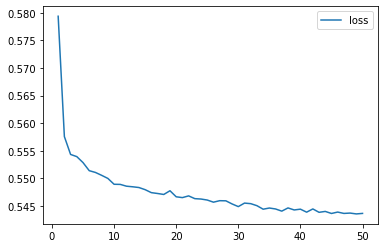

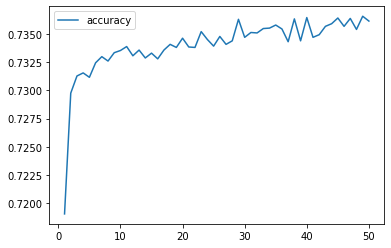

In [15]:

neuralRelu50 = neuralNetworkModel(activation="relu", epochs=50, hiddenNodesTimes=3)


Epoch 1/100
804/804 [==============================] - 1s 933us/step - loss: 0.5740 - accuracy: 0.7230
Epoch 2/100
804/804 [==============================] - 1s 933us/step - loss: 0.5589 - accuracy: 0.7297
Epoch 3/100
804/804 [==============================] - 1s 999us/step - loss: 0.5554 - accuracy: 0.7305
Epoch 4/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5547 - accuracy: 0.7304
Epoch 5/100
804/804 [==============================] - 1s 952us/step - loss: 0.5535 - accuracy: 0.7318
Epoch 6/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5524 - accuracy: 0.7329
Epoch 7/100
804/804 [==============================] - 1s 980us/step - loss: 0.5515 - accuracy: 0.7336
Epoch 8/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5512 - accuracy: 0.7312
Epoch 9/100
804/804 [==============================] - 1s 899us/step - loss: 0.5507 - accuracy: 0.7325
Epoch 10/100
804/804 [==============================] - 1s 906us/step - loss: 0

804/804 [==============================] - 1s 985us/step - loss: 0.5416 - accuracy: 0.7383
Epoch 80/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5410 - accuracy: 0.7380
Epoch 81/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5415 - accuracy: 0.7387
Epoch 82/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5410 - accuracy: 0.7383
Epoch 83/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5420 - accuracy: 0.7369
Epoch 84/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5415 - accuracy: 0.7371
Epoch 85/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5413 - accuracy: 0.7377
Epoch 86/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5413 - accuracy: 0.7379
Epoch 87/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5408 - accuracy: 0.7392
Epoch 88/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5412 - accuracy

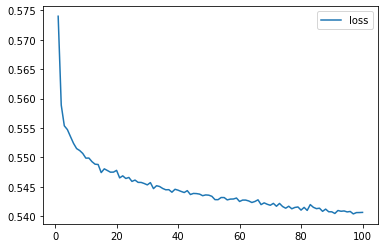

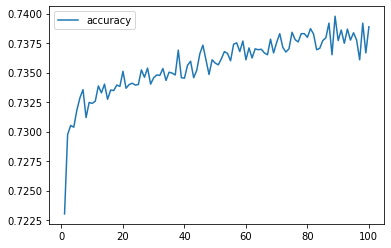

In [16]:

neuralRelu100 = neuralNetworkModel(activation="relu", epochs=100, hiddenNodesTimes=3)


Epoch 1/250
804/804 [==============================] - 1s 990us/step - loss: 0.5748 - accuracy: 0.7182
Epoch 2/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5585 - accuracy: 0.7294
Epoch 3/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5564 - accuracy: 0.7300
Epoch 4/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5538 - accuracy: 0.7309
Epoch 5/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5532 - accuracy: 0.7311
Epoch 6/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5520 - accuracy: 0.7314
Epoch 7/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5510 - accuracy: 0.7315
Epoch 8/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5507 - accuracy: 0.7310
Epoch 9/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5501 - accuracy: 0.7328
Epoch 10/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5493 - accu

804/804 [==============================] - 1s 897us/step - loss: 0.5411 - accuracy: 0.7381
Epoch 81/250
804/804 [==============================] - 1s 912us/step - loss: 0.5408 - accuracy: 0.7385
Epoch 82/250
804/804 [==============================] - 1s 914us/step - loss: 0.5408 - accuracy: 0.7383
Epoch 83/250
804/804 [==============================] - 1s 915us/step - loss: 0.5412 - accuracy: 0.7383
Epoch 84/250
804/804 [==============================] - 1s 939us/step - loss: 0.5409 - accuracy: 0.7378
Epoch 85/250
804/804 [==============================] - 1s 902us/step - loss: 0.5410 - accuracy: 0.7387
Epoch 86/250
804/804 [==============================] - 1s 892us/step - loss: 0.5412 - accuracy: 0.7371
Epoch 87/250
804/804 [==============================] - 1s 904us/step - loss: 0.5407 - accuracy: 0.7378
Epoch 88/250
804/804 [==============================] - 1s 903us/step - loss: 0.5409 - accuracy: 0.7383
Epoch 89/250
804/804 [==============================] - 1s 935us/step - loss:

804/804 [==============================] - 1s 964us/step - loss: 0.5380 - accuracy: 0.7400
Epoch 159/250
804/804 [==============================] - 1s 963us/step - loss: 0.5384 - accuracy: 0.7391
Epoch 160/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5382 - accuracy: 0.7395
Epoch 161/250
804/804 [==============================] - 1s 941us/step - loss: 0.5383 - accuracy: 0.7391
Epoch 162/250
804/804 [==============================] - 1s 973us/step - loss: 0.5379 - accuracy: 0.7399
Epoch 163/250
804/804 [==============================] - 1s 970us/step - loss: 0.5383 - accuracy: 0.7379
Epoch 164/250
804/804 [==============================] - 1s 993us/step - loss: 0.5387 - accuracy: 0.7385
Epoch 165/250
804/804 [==============================] - 1s 946us/step - loss: 0.5381 - accuracy: 0.7397
Epoch 166/250
804/804 [==============================] - 1s 953us/step - loss: 0.5382 - accuracy: 0.7393
Epoch 167/250
804/804 [==============================] - 1s 898us/step 

804/804 [==============================] - 1s 978us/step - loss: 0.5384 - accuracy: 0.7411
Epoch 237/250
804/804 [==============================] - 1s 991us/step - loss: 0.5366 - accuracy: 0.7393
Epoch 238/250
804/804 [==============================] - 1s 935us/step - loss: 0.5366 - accuracy: 0.7402
Epoch 239/250
804/804 [==============================] - 1s 949us/step - loss: 0.5364 - accuracy: 0.7410
Epoch 240/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5366 - accuracy: 0.7403
Epoch 241/250
804/804 [==============================] - 1s 1ms/step - loss: 0.5367 - accuracy: 0.7407
Epoch 242/250
804/804 [==============================] - 1s 932us/step - loss: 0.5367 - accuracy: 0.7396
Epoch 243/250
804/804 [==============================] - 1s 908us/step - loss: 0.5369 - accuracy: 0.7402
Epoch 244/250
804/804 [==============================] - 1s 953us/step - loss: 0.5373 - accuracy: 0.7398
Epoch 245/250
804/804 [==============================] - 1s 907us/step - 

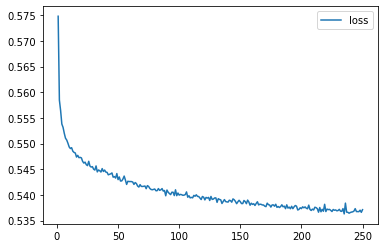

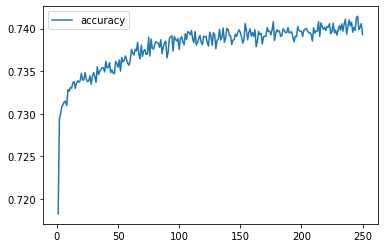

In [17]:

neuralRelu250 = neuralNetworkModel(activation="relu", epochs=250, hiddenNodesTimes=3)


Epoch 1/500
804/804 [==============================] - 1s 948us/step - loss: 0.5717 - accuracy: 0.7220
Epoch 2/500
804/804 [==============================] - 1s 930us/step - loss: 0.5581 - accuracy: 0.7287
Epoch 3/500
804/804 [==============================] - 1s 915us/step - loss: 0.5559 - accuracy: 0.7310
Epoch 4/500
804/804 [==============================] - 1s 940us/step - loss: 0.5537 - accuracy: 0.7318
Epoch 5/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5519 - accuracy: 0.7314
Epoch 6/500
804/804 [==============================] - 1s 927us/step - loss: 0.5510 - accuracy: 0.7339
Epoch 7/500
804/804 [==============================] - 1s 963us/step - loss: 0.5513 - accuracy: 0.7322
Epoch 8/500
804/804 [==============================] - 1s 908us/step - loss: 0.5503 - accuracy: 0.7327
Epoch 9/500
804/804 [==============================] - 1s 896us/step - loss: 0.5497 - accuracy: 0.7318
Epoch 10/500
804/804 [==============================] - 1s 901us/step - los

Epoch 81/500
804/804 [==============================] - 1s 993us/step - loss: 0.5413 - accuracy: 0.7381
Epoch 82/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5413 - accuracy: 0.7379
Epoch 83/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5409 - accuracy: 0.7385
Epoch 84/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5411 - accuracy: 0.7373
Epoch 85/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5412 - accuracy: 0.7371
Epoch 86/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5408 - accuracy: 0.7390
Epoch 87/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5408 - accuracy: 0.7381
Epoch 88/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5411 - accuracy: 0.7374
Epoch 89/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5410 - accuracy: 0.7381
Epoch 90/500
804/804 [==============================] - 1s 1ms/step - loss: 0.54

804/804 [==============================] - 1s 1ms/step - loss: 0.5386 - accuracy: 0.7394
Epoch 160/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5386 - accuracy: 0.7403
Epoch 161/500
804/804 [==============================] - 1s 988us/step - loss: 0.5384 - accuracy: 0.7377
Epoch 162/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5385 - accuracy: 0.7412
Epoch 163/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5388 - accuracy: 0.7398
Epoch 164/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5379 - accuracy: 0.7397
Epoch 165/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5386 - accuracy: 0.7396
Epoch 166/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5385 - accuracy: 0.7389
Epoch 167/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5378 - accuracy: 0.7403
Epoch 168/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5382 -

804/804 [==============================] - 1s 1ms/step - loss: 0.5368 - accuracy: 0.7404
Epoch 239/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5369 - accuracy: 0.7402
Epoch 240/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5376 - accuracy: 0.7404
Epoch 241/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5372 - accuracy: 0.7410
Epoch 242/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5371 - accuracy: 0.7404
Epoch 243/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5371 - accuracy: 0.7408
Epoch 244/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5379 - accuracy: 0.7399
Epoch 245/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5372 - accuracy: 0.7415
Epoch 246/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5372 - accuracy: 0.7402
Epoch 247/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5372 - a

804/804 [==============================] - 1s 1ms/step - loss: 0.5360 - accuracy: 0.7404
Epoch 318/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5360 - accuracy: 0.7407
Epoch 319/500
804/804 [==============================] - 1s 989us/step - loss: 0.5365 - accuracy: 0.7405
Epoch 320/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5364 - accuracy: 0.7399
Epoch 321/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5366 - accuracy: 0.7414
Epoch 322/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5360 - accuracy: 0.7419
Epoch 323/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5363 - accuracy: 0.7409
Epoch 324/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5359 - accuracy: 0.7405
Epoch 325/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5361 - accuracy: 0.7406
Epoch 326/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5369 -

804/804 [==============================] - 1s 939us/step - loss: 0.5354 - accuracy: 0.7406
Epoch 396/500
804/804 [==============================] - 1s 966us/step - loss: 0.5357 - accuracy: 0.7411
Epoch 397/500
804/804 [==============================] - 1s 943us/step - loss: 0.5354 - accuracy: 0.7408
Epoch 398/500
804/804 [==============================] - 1s 945us/step - loss: 0.5355 - accuracy: 0.7409
Epoch 399/500
804/804 [==============================] - 1s 918us/step - loss: 0.5361 - accuracy: 0.7405
Epoch 400/500
804/804 [==============================] - 1s 977us/step - loss: 0.5359 - accuracy: 0.7404
Epoch 401/500
804/804 [==============================] - 1s 938us/step - loss: 0.5355 - accuracy: 0.7414
Epoch 402/500
804/804 [==============================] - 1s 923us/step - loss: 0.5351 - accuracy: 0.7403
Epoch 403/500
804/804 [==============================] - 1s 948us/step - loss: 0.5356 - accuracy: 0.7408
Epoch 404/500
804/804 [==============================] - 1s 920us/ste

804/804 [==============================] - 1s 1ms/step - loss: 0.5350 - accuracy: 0.7413
Epoch 474/500
804/804 [==============================] - 1s 994us/step - loss: 0.5350 - accuracy: 0.7412
Epoch 475/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5353 - accuracy: 0.7414
Epoch 476/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5355 - accuracy: 0.7418
Epoch 477/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5348 - accuracy: 0.7424
Epoch 478/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5348 - accuracy: 0.7425
Epoch 479/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5349 - accuracy: 0.7418
Epoch 480/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5347 - accuracy: 0.7414
Epoch 481/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5346 - accuracy: 0.7418
Epoch 482/500
804/804 [==============================] - 1s 1ms/step - loss: 0.5347 -

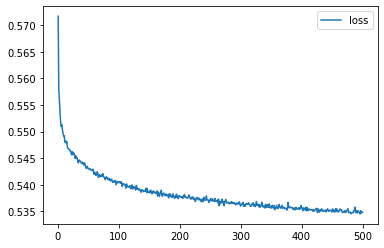

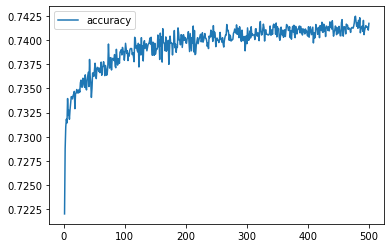

In [18]:

neuralRelu500 = neuralNetworkModel(activation="relu", epochs=500, hiddenNodesTimes=3)


In [19]:
# Summary of RELU executions with different epoch

print(neuralRelu50)
print("\n#################################################")
print(neuralRelu100)
print("\n#################################################")
print(neuralRelu250)
print("\n#################################################")
print(neuralRelu500)
print("\n#################################################")


    Neural Network (with one hidden layer)
    Number of Inputs: 41
    Number of Hidden Nodes: 123
    Activation function: relu
    Epochs: 50
    Loss: 0.5551213026046753
    Accuracy: 0.7261807322502136

#################################################

    Neural Network (with one hidden layer)
    Number of Inputs: 41
    Number of Hidden Nodes: 123
    Activation function: relu
    Epochs: 100
    Loss: 0.5536872148513794
    Accuracy: 0.7261807322502136

#################################################

    Neural Network (with one hidden layer)
    Number of Inputs: 41
    Number of Hidden Nodes: 123
    Activation function: relu
    Epochs: 250
    Loss: 0.5582009553909302
    Accuracy: 0.7258309125900269

#################################################

    Neural Network (with one hidden layer)
    Number of Inputs: 41
    Number of Hidden Nodes: 123
    Activation function: relu
    Epochs: 500
    Loss: 0.5635718107223511
    Accuracy: 0.7255976796150208

###########

Epoch 1/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5885 - accuracy: 0.7129
Epoch 2/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5776 - accuracy: 0.7206
Epoch 3/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5748 - accuracy: 0.7234
Epoch 4/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5723 - accuracy: 0.7249
Epoch 5/50
804/804 [==============================] - 1s 994us/step - loss: 0.5699 - accuracy: 0.7260
Epoch 6/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5668 - accuracy: 0.7271
Epoch 7/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5633 - accuracy: 0.7285
Epoch 8/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5607 - accuracy: 0.7312
Epoch 9/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5580 - accuracy: 0.7318
Epoch 10/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5561 - accuracy: 0.73

804/804 [==============================] - 1s 1ms/step - loss: 0.5490 - accuracy: 0.7322
Epoch 32/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5485 - accuracy: 0.7331
Epoch 33/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5486 - accuracy: 0.7331
Epoch 34/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5485 - accuracy: 0.7329
Epoch 35/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5491 - accuracy: 0.7338
Epoch 36/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5483 - accuracy: 0.7335
Epoch 37/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5484 - accuracy: 0.7320
Epoch 38/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5482 - accuracy: 0.7333
Epoch 39/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5482 - accuracy: 0.7341
Epoch 40/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5479 - accuracy: 0.7337
Ep

804/804 [==============================] - 1s 1ms/step - loss: 0.5555 - accuracy: 0.7300
Epoch 12/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5558 - accuracy: 0.7289
Epoch 13/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5556 - accuracy: 0.7282
Epoch 14/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5543 - accuracy: 0.7298
Epoch 15/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5546 - accuracy: 0.7296
Epoch 16/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5546 - accuracy: 0.7294
Epoch 17/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5544 - accuracy: 0.7302
Epoch 18/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5540 - accuracy: 0.7318
Epoch 19/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5534 - accuracy: 0.7304
Epoch 20/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5532 - accuracy: 0.7309
Ep

804/804 [==============================] - 1s 1ms/step - loss: 0.5396 - accuracy: 0.7398
Epoch 42/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5394 - accuracy: 0.7402
Epoch 43/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5394 - accuracy: 0.7404
Epoch 44/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5393 - accuracy: 0.7401
Epoch 45/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5393 - accuracy: 0.7405
Epoch 46/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5392 - accuracy: 0.7401
Epoch 47/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5391 - accuracy: 0.7399
Epoch 48/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5389 - accuracy: 0.7405
Epoch 49/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5390 - accuracy: 0.7406
Epoch 50/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5389 - accuracy: 0.7404
26

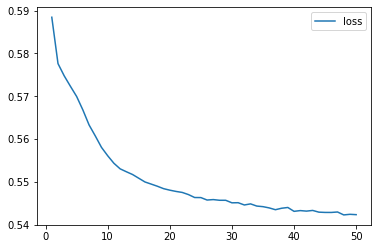

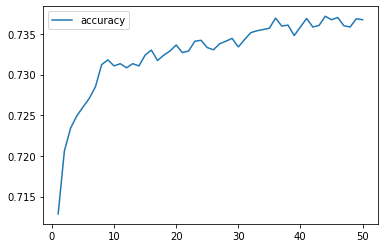

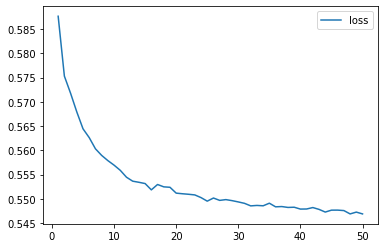

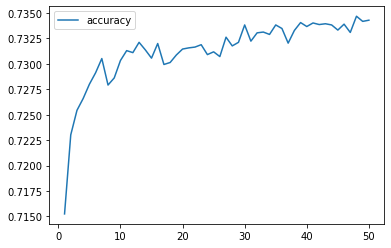

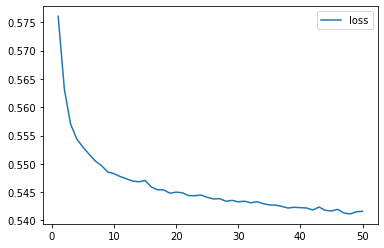

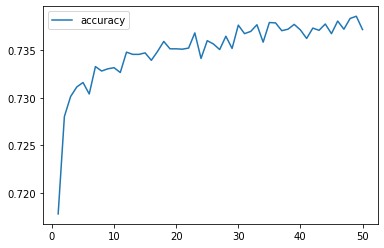

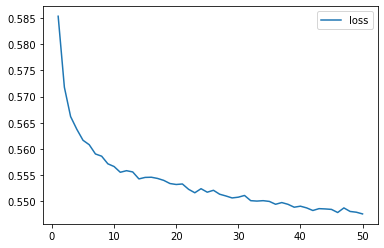

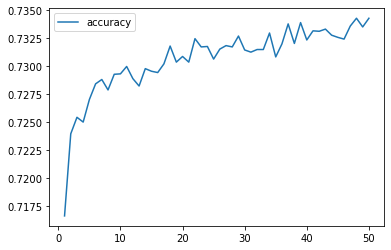

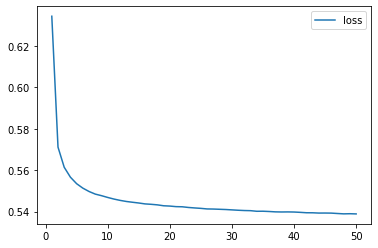

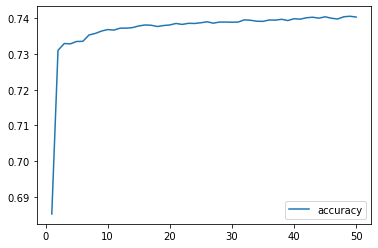

In [20]:
# Try with other activation functions to see if we improve accuracy
neuralSigmoid50 = neuralNetworkModel(activation="sigmoid", epochs=50, hiddenNodesTimes=3)
neuralSelu50 = neuralNetworkModel(activation="selu", epochs=50, hiddenNodesTimes=3)
neuralSoftsign50 = neuralNetworkModel(activation="softsign", epochs=50, hiddenNodesTimes=3)
neuralSoftplus50 = neuralNetworkModel(activation="softplus", epochs=50, hiddenNodesTimes=3)
neuralSoftmax50 = neuralNetworkModel(activation="softmax", epochs=50, hiddenNodesTimes=3)


In [21]:
print(neuralSigmoid50)
print("\n#################################################")
print(neuralSelu50)
print("\n#################################################")
print(neuralSoftsign50)
print("\n#################################################")
print(neuralSoftplus50)
print("\n#################################################")
print(neuralSoftmax50)
print("\n#################################################")



    Neural Network (with one hidden layer)
    Number of Inputs: 41
    Number of Hidden Nodes: 123
    Activation function: sigmoid
    Epochs: 50
    Loss: 0.5525164604187012
    Accuracy: 0.7254810333251953

#################################################

    Neural Network (with one hidden layer)
    Number of Inputs: 41
    Number of Hidden Nodes: 123
    Activation function: selu
    Epochs: 50
    Loss: 0.556538462638855
    Accuracy: 0.7241982221603394

#################################################

    Neural Network (with one hidden layer)
    Number of Inputs: 41
    Number of Hidden Nodes: 123
    Activation function: softsign
    Epochs: 50
    Loss: 0.5541245341300964
    Accuracy: 0.726064145565033

#################################################

    Neural Network (with one hidden layer)
    Number of Inputs: 41
    Number of Hidden Nodes: 123
    Activation function: softplus
    Epochs: 50
    Loss: 0.5573101043701172
    Accuracy: 0.72116619348526

#######

Epoch 1/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5718 - accuracy: 0.7213
Epoch 2/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5587 - accuracy: 0.7300
Epoch 3/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5569 - accuracy: 0.7315
Epoch 4/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5534 - accuracy: 0.7312
Epoch 5/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5529 - accuracy: 0.7308
Epoch 6/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5521 - accuracy: 0.7309
Epoch 7/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5514 - accuracy: 0.7340
Epoch 8/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5513 - accuracy: 0.7313
Epoch 9/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5508 - accuracy: 0.7319
Epoch 10/50
804/804 [==============================] - 1s 1ms/step - loss: 0.5502 - accuracy: 0.7315

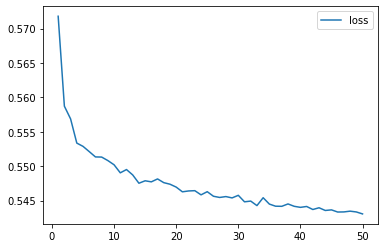

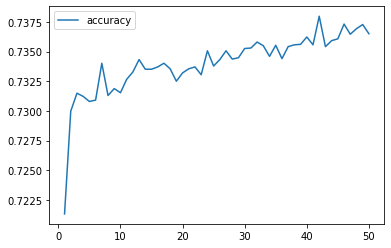

In [22]:
# Try increase the number of nodes (Not using the Thumb rule) to see if we improve accuracy
neuralRelu5Times50 = neuralNetworkModel(activation="relu", epochs=50, hiddenNodesTimes=5)
print(neuralSoftmax50)
print("\n#################################################")

In [23]:

# Let us see if a deep learning model will improve accuracy
# **************************************************************

def deepLearningModel(activation, epochs, hiddenNodes1, hiddenNodes2) -> str:

    # Define the model - deep neural net
    numberInputFeatures = len(XTrainScaled[0])
    hiddenNodesLayer1 =  hiddenNodes1 
    hiddenNodesLayer2 = hiddenNodes2 

    nNet = Sequential()

    # First hidden layer
    nNet.add(
        Dense(units=hiddenNodesLayer1, input_dim=numberInputFeatures, activation="relu")
    )

    # Second hidden layer
    nNet.add(Dense(units=hiddenNodesLayer2, activation=activation))

    # Output layer
    nNet.add(Dense(units=1, activation="sigmoid"))
        
    # Check the structure of the model
    nNet.summary()
    
    # Compile the model
    nNet.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    # TRAIN AND EVALUATE THE MODEL
    # *******************************

    # Train the model
    fitmodel = nNet.fit(XTrain, yTrain, epochs=epochs)
    
    # Evaluate the model using the test data
    modelLoss, modelAccuracy = nNet.evaluate(XTest, yTest, verbose=2)
    result = f"Loss: {modelLoss}, Accuracy: {modelAccuracy}"
    result = f"""
    Deep Learning Model (two hidden layer)
    {nNet.summary()}
    Activation function: {activation}
    Epochs: {epochs}
    Loss: {modelLoss}
    Accuracy: {modelAccuracy}"""
    return result

In [24]:

deepRelu50_10 = deepLearningModel(activation="relu",epochs=50,hiddenNodes1=10,hiddenNodes2=5)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 10)                420       
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 6         
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
804/804 [==============================] - 1s 960us/step - loss: 46104.7461 - accuracy: 0.5097
Epoch 2/50
804/804 [==============================] - 1s 1ms/step - loss: 19444.4531 - accuracy: 0.5012
Epoch 3/50
804/804 [==============================] - 1s 990us/step - loss: 15410.8486 - accuracy: 0.4972
Epoch 4/50
804/804 [==============================] - 1s 1ms/step - l

In [25]:

deepRelu100_10 = deepLearningModel(activation="relu",epochs=100,hiddenNodes1=10,hiddenNodes2=5)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 10)                420       
_________________________________________________________________
dense_24 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 6         
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
804/804 [==============================] - 1s 950us/step - loss: 63798.8359 - accuracy: 0.4998
Epoch 2/100
804/804 [==============================] - 1s 976us/step - loss: 0.7046 - accuracy: 0.4679
Epoch 3/100
804/804 [==============================] - 1s 960us/step - loss: 0.6933 - accuracy: 0.5030
Epoch 4/100
804/804 [==============================] - 1s 944us/step - l

804/804 [==============================] - 1s 1ms/step - loss: 0.6911 - accuracy: 0.5321
Epoch 74/100
804/804 [==============================] - 1s 990us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 75/100
804/804 [==============================] - 1s 976us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 76/100
804/804 [==============================] - 1s 898us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 77/100
804/804 [==============================] - 1s 974us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 78/100
804/804 [==============================] - 1s 947us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 79/100
804/804 [==============================] - 1s 915us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 80/100
804/804 [==============================] - 1s 945us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 81/100
804/804 [==============================] - 1s 913us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 82/100
804/804 [==============================] - 1s 958us/step - loss: 0

In [26]:

deepRelu50_20 = deepLearningModel(activation="relu",epochs=50,hiddenNodes1=20,hiddenNodes2=5)


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 20)                840       
_________________________________________________________________
dense_27 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 6         
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
804/804 [==============================] - 1s 890us/step - loss: 3728.3408 - accuracy: 0.5185
Epoch 2/50
804/804 [==============================] - 1s 932us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 3/50
804/804 [==============================] - 1s 1ms/step - loss: 0.6911 - accuracy: 0.5321
Epoch 4/50
804/804 [==============================] - 1s 981us/step - loss: 0.

In [27]:

deepRelu100_20 = deepLearningModel(activation="relu",epochs=100,hiddenNodes1=20,hiddenNodes2=5)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 20)                840       
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 105       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 6         
Total params: 951
Trainable params: 951
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
804/804 [==============================] - 1s 983us/step - loss: 2246.1892 - accuracy: 0.5092
Epoch 2/100
804/804 [==============================] - 1s 1ms/step - loss: 0.6913 - accuracy: 0.5321
Epoch 3/100
804/804 [==============================] - 1s 989us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 4/100
804/804 [==============================] - 1s 925us/step - loss

804/804 [==============================] - 1s 974us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 74/100
804/804 [==============================] - 1s 952us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 75/100
804/804 [==============================] - 1s 984us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 76/100
804/804 [==============================] - 1s 990us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 77/100
804/804 [==============================] - 1s 959us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 78/100
804/804 [==============================] - 1s 1ms/step - loss: 0.6911 - accuracy: 0.5321
Epoch 79/100
804/804 [==============================] - 1s 978us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 80/100
804/804 [==============================] - 1s 994us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 81/100
804/804 [==============================] - 1s 994us/step - loss: 0.6911 - accuracy: 0.5321
Epoch 82/100
804/804 [==============================] - 1s 1ms/step - loss: 0.6

In [28]:

print(deepRelu50_10)
print("\n#################################################")
print(deepRelu100_10)
print("\n#################################################")
print(deepRelu50_20)
print("\n#################################################")
print(deepRelu100_20)
print("\n#################################################")



    Deep Learning Model (two hidden layer)
    None
    Activation function: relu
    Epochs: 50
    Loss: 0.6831672191619873
    Accuracy: 0.5331778526306152

#################################################

    Deep Learning Model (two hidden layer)
    None
    Activation function: relu
    Epochs: 100
    Loss: 0.6909440755844116
    Accuracy: 0.5331778526306152

#################################################

    Deep Learning Model (two hidden layer)
    None
    Activation function: relu
    Epochs: 50
    Loss: 0.6909657716751099
    Accuracy: 0.5331778526306152

#################################################

    Deep Learning Model (two hidden layer)
    None
    Activation function: relu
    Epochs: 100
    Loss: 0.6909482479095459
    Accuracy: 0.5331778526306152

#################################################
